1.Import Libraries and Define Hyperparameters

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Hyperparameters
BATCH_SIZE = 64  # Batch size for training and testing
EPOCHS = 10  # Number of training epochs
PATCH_SIZE = 16  # Size of each image patch
EMBED_DIM = 64  # Dimension of patch embeddings
NUM_HEADS = 4  # Number of attention heads
NUM_LAYERS = 6  # Number of Transformer encoder layers
NUM_CLASSES = 10  # Number of output classes (CIFAR-10)
LEARNING_RATE = 1e-3  # Learning rate for optimizer

2.Prepare the Dataset and DataLoader

In [13]:
# Define transforms: normalize images and convert to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Load CIFAR-10 dataset (training subset)
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
subset_size = int(len(full_dataset) * 0.2)  # Use only 20% of the training set
subset_indices = torch.randperm(len(full_dataset))[:subset_size]
train_data = Subset(full_dataset, subset_indices)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Load CIFAR-10 test set
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


3. Define the Vision Transformer Components

Path Embedding Layer

In [14]:
class PatchEmbedding(nn.Module):
    """Converts an image into a sequence of flattened patch embeddings."""
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # Shape: [B, embed_dim, num_patches_height, num_patches_width]
        x = x.flatten(2).transpose(1, 2)  # Shape: [B, num_patches, embed_dim]
        return x


Transformer Encoder Block

In [15]:
class TransformerEncoder(nn.Module):
    """Single Transformer encoder block with self-attention and MLP."""
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)  # Self-attention
        x = x + attn_output  # Residual connection
        x = self.norm1(x)  # Normalize
        x = x + self.mlp(x)  # MLP and residual connection
        x = self.norm2(x)  # Normalize
        return x


Vision Transformer (ViT)

In [16]:
class VisionTransformer(nn.Module):
    """Vision Transformer model for image classification."""
    def __init__(self, img_size, patch_size, embed_dim, num_heads, num_layers, num_classes):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # Class token
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))  # Positional encoding
        self.encoder = nn.ModuleList([
            TransformerEncoder(embed_dim, num_heads, mlp_dim=embed_dim * 4) for _ in range(num_layers)
        ])
        self.head = nn.Linear(embed_dim, num_classes)  # Classification head

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)  # Patch embeddings
        cls_token = self.cls_token.expand(B, -1, -1)  # Expand class token for each batch
        x = torch.cat((cls_token, x), dim=1)  # Prepend class token
        x = x + self.pos_embed  # Add positional encoding
        for layer in self.encoder:
            x = layer(x)  # Pass through Transformer layers
        return self.head(x[:, 0])  # Use class token output for classification


4. Initialize Model, Optimizer, and Loss Function

In [17]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Vision Transformer model
model = VisionTransformer(
    img_size=32, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS, num_layers=NUM_LAYERS, num_classes=NUM_CLASSES
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Adam optimizer


5. Define Training and Evaluation Functions

In [18]:
def train_model(model, loader, optimizer, criterion, device):
    model.train()  # Set to training mode
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

In [19]:
def evaluate_model(model, loader, device):
    model.eval()  # Set to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)  # Get predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total * 100  # Return accuracy percentage


6. Train and Evaluate the Model

In [20]:
train_losses, test_accuracies = [], []

for epoch in range(EPOCHS):
    # Train
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # Evaluate
    test_accuracy = evaluate_model(model, test_loader, device)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/10, Loss: 2.3234, Test Accuracy: 10.00%
Epoch 2/10, Loss: 2.3129, Test Accuracy: 10.00%
Epoch 3/10, Loss: 2.3134, Test Accuracy: 10.00%
Epoch 4/10, Loss: 2.3088, Test Accuracy: 10.00%
Epoch 5/10, Loss: 2.3100, Test Accuracy: 10.00%
Epoch 6/10, Loss: 2.3083, Test Accuracy: 10.00%
Epoch 7/10, Loss: 2.3098, Test Accuracy: 10.00%
Epoch 8/10, Loss: 2.3079, Test Accuracy: 10.00%
Epoch 9/10, Loss: 2.3065, Test Accuracy: 10.00%
Epoch 10/10, Loss: 2.3069, Test Accuracy: 10.00%


7. Plot Training Loss and Test Accuracy

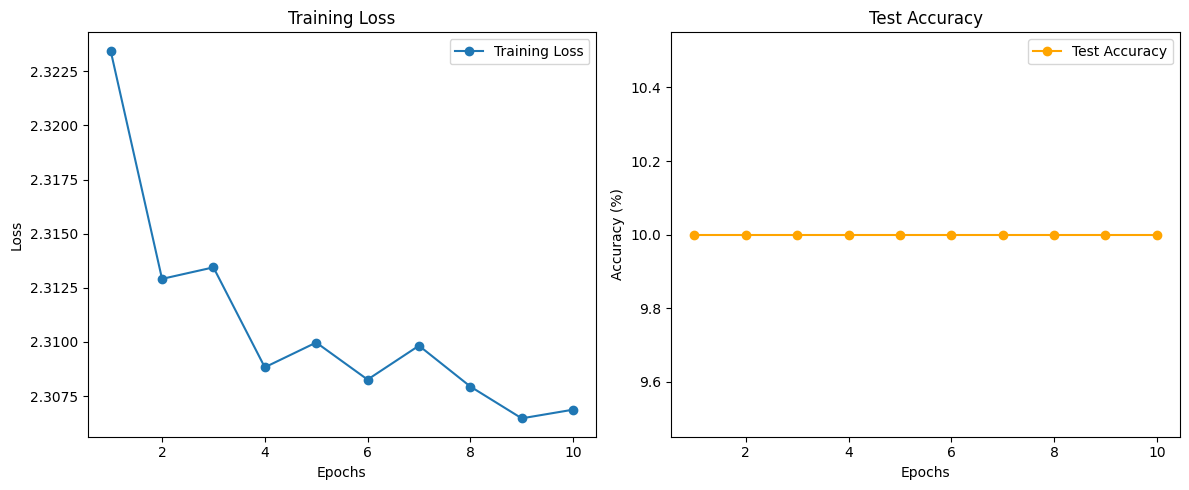

In [21]:
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), test_accuracies, marker='o', color='orange', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
